## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import io
import csv
import os
#시드값 고정
np.random.seed(42)
%matplotlib inline

#KoNLPy 공식 문서 : https://konlpy.org/ko/latest/
#설치되었는지 확인 : pip install konlpy
from konlpy.tag import Hannanum, Kkma, Komoran, Okt
#LDA : 빈도수 기반 CountVectorizer 사용
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import gensim
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

In [ ]:
'''
한글 폰트 적용
------Jupyter Notebook----- 
from matplotlib import font_manager as fm

f_path = 'C:/windows/Fonts/malgun.ttf'
fm.FontProperties(fname=f_path).get_name()
mpl.rc('font', family='Malgun Gothic')


------Code Lab------
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
'''

mpl.rc('font', family='NanumBarunGothic') 

In [ ]:
# 그림 저장
image_path = '/content/drive/MyDrive/LIS3813/images/'

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    #해상도 dpi=300
    path = image_path + fig_name + "." + fig_extension
    print("그림 저장: ", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#데이터 불러오기
#한글 전용 인코딩 방식 'cp949'으로 읽어오기
#Unnamed: 0 열 drop
df_article = pd.read_csv('/content/drive/MyDrive/LIS3813/datasets/df_article.csv', engine='python', encoding='cp949').drop('Unnamed: 0' , axis=1)

df_article

,date,sentence,label
0,2022-05-29 23:26:00,내일 군대가네,clean
1,2022-05-29 23:26:00,잘 다녀오겠습니다~,clean
2,2022-05-27 23:59:00,에스파 역시나 고대 축제에서도 립싱크하던데,clean
3,2022-05-27 23:59:00,닝닝 고음파트에서 마이크 조정하는척 하는거 존웃,clean
4,2022-05-29 22:54:00,rc101이고 rc자기주도고 이젠 그냥 RC 붙은 것들 보기만 해도 발작 일어날 것 같음,악플/욕설
...,...,...,...
95295,2021-02-16 02:41:00,"만약 여러분이 지방에 있는 경우, 경기권이거나 서울에 한두번쯤은 부담없이 올라갈 수...",clean
95296,2021-02-16 02:41:00,"5. 뻔선, 엑스맨, 학생회가 아닌 그 외의 선배들",clean
95297,2021-02-16 02:41:00,위에서 언급했다시피 밥약은 보통 2:2 혹은 3:3으로 진행된다!! 그 밥약에서 만...,clean
95298,2021-02-16 02:41:00,6. 밥약을 걸 때,clean


In [ ]:
df_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95300 entries, 0 to 95299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      95300 non-null  object
 1   sentence  95300 non-null  object
 2   label     95300 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


In [ ]:
#Unnamed: 0 열 drop
df_comment = pd.read_csv('/content/drive/MyDrive/LIS3813/datasets/df_comment.csv', engine='python', encoding='cp949').drop('Unnamed: 0' , axis=1)

df_comment

,date,sentence,label
0,2022-05-29 23:26:00,몸 조심해,clean
1,2022-05-29 23:27:00,다치지마…,clean
2,2022-05-29 23:27:00,ㅂㅂ 화이팅,clean
3,2022-05-29 23:27:00,좋은 말씀 감사합니다 다들 응원해주셔서 고마워요 ㅎㅎ 공군 838기 파이팅,clean
4,2022-05-29 23:33:00,힝 ㅠㅠ 뭐라쓰셨어ㅋㅋㅋㅋ요 ?,clean
...,...,...,...
320123,2021-02-16 17:04:00,코로난데 밥약도 걸어?,clean
320124,2021-02-16 22:41:00,말했자어 그렇게 심각하지 않을때 세네번 해봄,clean
320125,2021-02-16 23:39:00,???과대 80만워 줘??나 과대인데 왜 안줌...,clean
320126,2021-02-17 02:33:00,학기 말에 받아!!,clean


In [ ]:
df_comment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320128 entries, 0 to 320127
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   date      320128 non-null  object
 1   sentence  320128 non-null  object
 2   label     320128 non-null  object
dtypes: object(3)
memory usage: 7.3+ MB


In [ ]:
df_list = [df_article, df_comment]

for df in df_list:
    #datetime으로 data type 변경
    df['date'] = pd.to_datetime(df['date'])
    
    #연도, 월 column 만들기
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    #날짜 column drop
    df.drop('date', axis=1, inplace=True)
    print(df.columns)

Index(['sentence', 'label', 'year', 'month'], dtype='object')
Index(['sentence', 'label', 'year', 'month'], dtype='object')


In [ ]:
df = pd.concat([df_article, df_comment])

df

,sentence,label,year,month
0,내일 군대가네,clean,2022,5
1,잘 다녀오겠습니다~,clean,2022,5
2,에스파 역시나 고대 축제에서도 립싱크하던데,clean,2022,5
3,닝닝 고음파트에서 마이크 조정하는척 하는거 존웃,clean,2022,5
4,rc101이고 rc자기주도고 이젠 그냥 RC 붙은 것들 보기만 해도 발작 일어날 것 같음,악플/욕설,2022,5
...,...,...,...,...
320123,코로난데 밥약도 걸어?,clean,2021,2
320124,말했자어 그렇게 심각하지 않을때 세네번 해봄,clean,2021,2
320125,???과대 80만워 줘??나 과대인데 왜 안줌...,clean,2021,2
320126,학기 말에 받아!!,clean,2021,2


In [ ]:
df = df[['year', 'month', 'label', 'sentence']]

df.head(3)

,year,month,label,sentence
0,2022,5,clean,내일 군대가네
1,2022,5,clean,잘 다녀오겠습니다~
2,2022,5,clean,에스파 역시나 고대 축제에서도 립싱크하던데


In [ ]:
#중복값 확인
df[df.duplicated(keep=False)]

,year,month,label,sentence
31,2022,5,clean,?? : 연세 도시공학과에서 일일호프를 연대!
32,2022,5,clean,?? : 뭐라고? 도대체 몇 년 만이지?! 이건 꼭 가야 해!
33,2022,5,clean,?? : 다 같이 떼창도 하면서 잊을 수 없는 추억을 만들 거래! 물론 썸 같은 것...
34,2022,5,clean,?? : 우리 당장 갈래??
35,2022,5,clean,??꿀잼 보장 합석 가능??
...,...,...,...,...
320077,2021,2,clean,넹
320080,2021,2,clean,(알수)
320084,2022,2,clean,감사합니다
320085,2021,2,clean,(알수)


In [ ]:
#중복값 제거
df = df.drop_duplicates()

In [ ]:
#혐오표현만 가져오기
df_hate = df[df['label'] != 'clean']
df_hate.head()

,year,month,label,sentence
4,2022,5,악플/욕설,rc101이고 rc자기주도고 이젠 그냥 RC 붙은 것들 보기만 해도 발작 일어날 것 같음
5,2022,5,악플/욕설,좆같은 거 그만 시켜
6,2022,5,악플/욕설,그만 괴롭혀줘 씨발 제발
17,2022,5,기타 혐오,정신병겜 응원하는 사람들이라 그런지 정신병이 확실하구만
25,2022,5,악플/욕설,아니면 알면서 시민단체 지원금과 자기 이력서에 추가할 스펙을 위해 이 모순을 회피하...


In [ ]:
df_hate.shape

(56974, 4)

In [ ]:
#label에서 '악플/욕설' 있는 데이터 개수 확인해보기
df_hate[df_hate.label.str.contains('악플/욕설')].count()

year        38816
month       38816
label       38816
sentence    38816
dtype: int64

In [ ]:
#복제본 만들기
df_hate_copy = df_hate.copy()

In [ ]:
df_conflict = df_hate[df_hate['label'] != '악플/욕설']

df_conflict['label'].unique()

array(['기타 혐오', '종교', '인종/국적', '여성/가족', '연령', '성소수자', '남성', '지역'],
      dtype=object)

In [ ]:
#이모티콘 제거하기 
df_conflict['sentence'].astype(str).apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
df_conflict

,year,month,label,sentence
17,2022,5,기타 혐오,정신병겜 응원하는 사람들이라 그런지 정신병이 확실하구만
150,2022,5,종교,유튜브 먹방/브이로그 끊으니까 식욕 개줄어든닼ㅋㅋㅋㅋ
191,2022,5,인종/국적,젖닌들이 코파 수준 드립치면 웃긴게
242,2022,5,기타 혐오,개삼성 제발 해체
325,2022,5,여성/가족,"사회전부가 외모, 숫자에 집착하는데 그것도 개도국일때나 쓸모있지"
...,...,...,...,...
319144,2021,2,기타 혐오,학교가 일반 학과 두 배는 되는 등록금 받으면서 국제대 기생학과 만들어논 것도 좀 ...
319166,2021,2,인종/국적,어떻게 경제학부가 국제대 시스템의 수혜자라는 댓글이 추천을 26개나 받을 수가 있음...
319582,2021,2,여성/가족,여자는 마른 게 진리 같다
319809,2021,2,연령,불꽃 15 틀딱 지나갑니다


In [ ]:
#2021년도 데이터
df_2021 = df_conflict.loc[df_conflict['year']==2021]

print(df_2021['year'].unique())

#월별 데이터 분포
df_2021[['year']].groupby(df_2021['month']).count() #2021년은 2~12월만 있음

[2021]


,year
month,
2,320
3,646
4,1085
5,1174
6,865
7,889
8,506
9,1084
10,1605


In [ ]:
#2022년도 데이터
df_2022 = df_conflict.loc[df_conflict['year']==2022]

print(df_2022['year'].unique())
print(df_2022['month'].unique()) #2022년은 1~5월만 있음

#월별 데이터 분포
df_2022[['year']].groupby(df_2022['month']).count()

[2022]
[5 4 3 2 1]


,year
month,
1,1311
2,1499
3,2073
4,1239
5,1467


In [ ]:
df_year_lst = [df_2021, df_2022]
df_Q1_lst = [] 
df_Q2_lst = []
df_Q3_lst = []
df_Q4_lst = []

#분기별로 데이터 분리
for df in df_year_lst:
    #1분기(1~3월)
    condition1 = df['month'] <= 3
    df_Q1_lst.append(df[condition1])
    
    #2분기(4~6월)
    condition2 = (df['month'] > 3) & (df['month'] <= 6)
    df_Q2_lst.append(df[condition2])
    
    #3분기(7~9월) 
    condition3 = (df['month'] > 6) & (df['month'] <= 9)
    df_Q3_lst.append(df[condition3])
    
    #4분기(10~12월)
    condition4 = df['month'] > 9
    df_Q4_lst.append(df[condition4])    

df_2021_Q1 = df_Q1_lst[0]
df_2021_Q1.to_csv('/content/drive/MyDrive/LIS3813/datasets/df_2021_Q1.csv')

df_2022_Q1 = df_Q1_lst[1]
df_2022_Q1.to_csv('/content/drive/MyDrive/LIS3813/datasets/df_2022_Q1.csv')

df_2021_Q2 = df_Q2_lst[0]
df_2021_Q2.to_csv('/content/drive/MyDrive/LIS3813/datasets/df_2021_Q2.csv')

df_2022_Q2 = df_Q2_lst[1]
df_2022_Q2.to_csv('/content/drive/MyDrive/LIS3813/datasets/df_2022_Q2.csv')

df_2021_Q3 = df_Q3_lst[0]
df_2021_Q3.to_csv('/content/drive/MyDrive/LIS3813/datasets/df_2021_Q3.csv')

df_2021_Q4 = df_Q4_lst[0]
df_2021_Q4.to_csv('/content/drive/MyDrive/LIS3813/datasets/df_2021_Q4.csv')

In [ ]:
df_all = [df_2021_Q1, df_2021_Q2, df_2021_Q3, df_2021_Q4, df_2022_Q1, df_2022_Q2]

그림 저장:  label_distribution


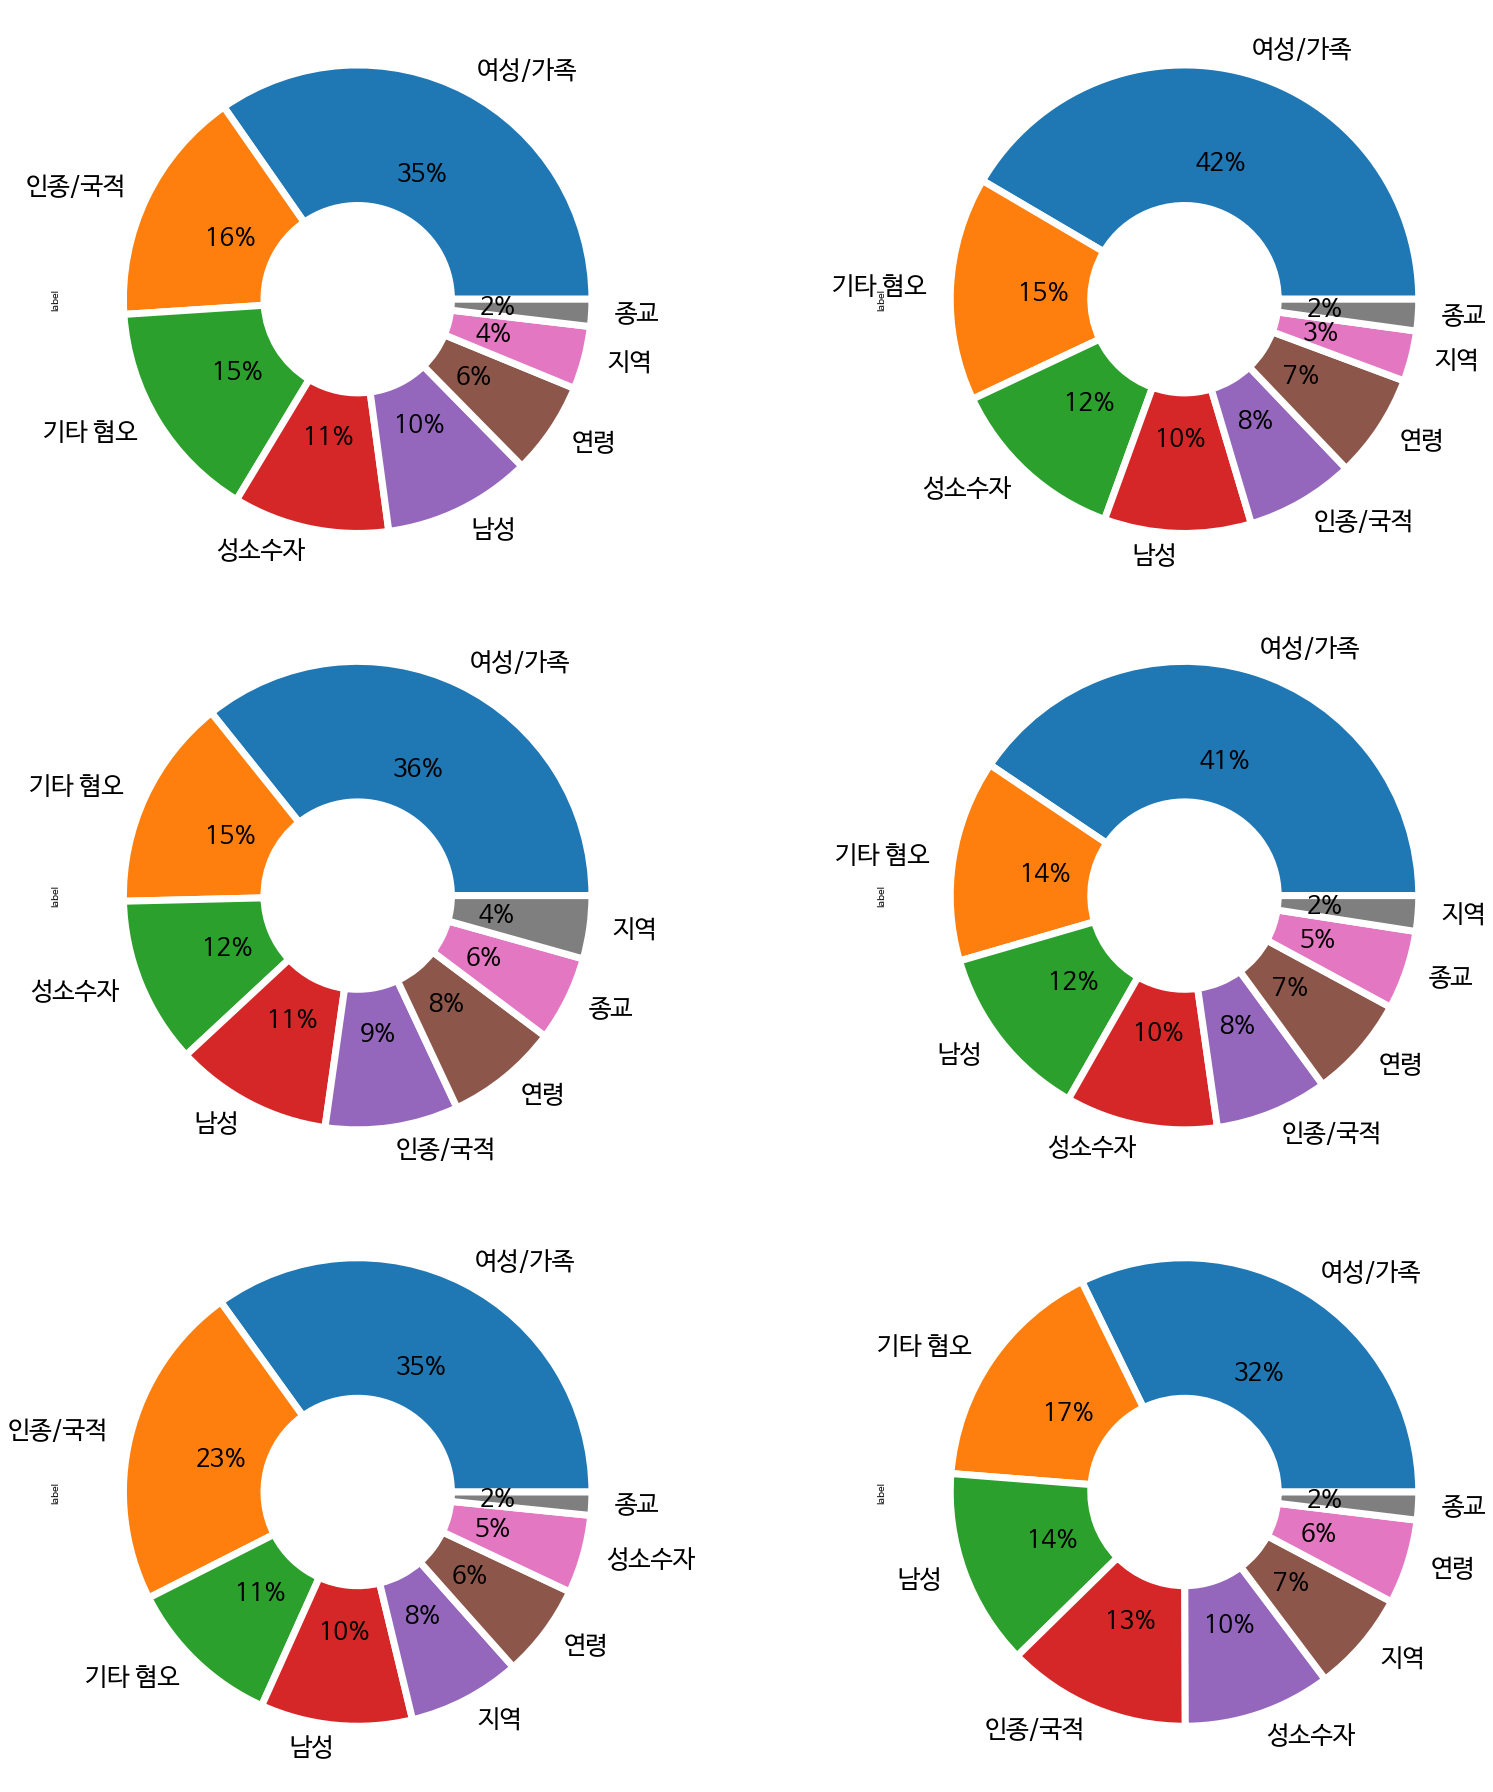

In [ ]:
#각 연도/분기마다의 label 분포
for i, df in enumerate(df_all):
    label = df['label']
    wedgeprops={'width': 0.6, 'edgecolor': 'w', 'linewidth': 7}
    xyi = f'32{i+1}'
    plt.subplot(int(xyi))
    label.value_counts().plot.pie(autopct='%1.0f%%',  wedgeprops=wedgeprops, figsize=(25,25), fontsize=25)#정수까지
    i +=1
    
save_fig('label_distribution')
#df[['sentence']].groupby(df['label']).count().sort_values('sentence', ascending=False).plot.bar()


In [ ]:
hannanum = Hannanum()
kkma = Kkma()
komoran = Komoran()
okt = Okt()

def get_nounsList(df):
    sentence_list = df['sentence'].values.tolist()
    nouns_list = []
    ignore_list = ['!!!', '학기', '연세대', '새끼', '이름', '!!', '이때', 'ㅇㅇ', 'XX', '보니', '세상', '개뿔', '조금',
                  '하면', '끼리', 'https', 'archive', 'Archive', 'Internet', '오늘', '처음', '느낌', 'yonsei', '.kr',
                  '.ac', 'Hello', 'Yonsei', 'University', 'Official', 'English', 'We', 'will', 'Everytime', '연세대학교 신촌캠퍼스',
                  '춘추', '진짜', '정말', '제발', '에타', 'ㄹㅇ', '이후', '있음', '없음', '대충', '아마', '언제', '제일', '팬티', '하라', '경우', '혼자', '연대', '게시판', '댓글', '하면서', '전부', '하다', '에바', '요즘', '레알', '개추', '약간',
                   '애초', '내가', '이유', '없어', '문제', '소리', '정도', '무엇', '이것', '저것', '사실', '필요', '존재', '생각',
                   '사람', '자체', '생각', '나도', '지금', '이제', 
                   ], 

    for sentence in tqdm(sentence_list):
        #pos : 품사와 함께 추출
        nouns = kkma.pos(sentence)
        for pos in nouns:
            #일반명사(NNG) 고유명사(NNP) 외국어(SL)
            if (pos[1] == 'NNG') or (pos[1] == 'NNP') or (pos[1] == 'SL'):
                #2음절 이상
                if (len(pos[0]) >= 2) and (pos[0] not in ignore_list):
                    nouns_list.append(pos[0])
                    
                
    return nouns_list

In [ ]:
df_2021_Q1 = pd.read_csv('/content/drive/MyDrive/LIS3813/datasets/df_2021_Q1.csv', engine='python')
df_2021_Q2 = pd.read_csv('/content/drive/MyDrive/LIS3813/datasets/df_2021_Q2.csv', engine='python')
df_2021_Q3 = pd.read_csv('/content/drive/MyDrive/LIS3813/datasets/df_2021_Q3.csv', engine='python')
df_2021_Q4 = pd.read_csv('/content/drive/MyDrive/LIS3813/datasets/df_2021_Q4.csv', engine='python')
df_2022_Q1 = pd.read_csv('/content/drive/MyDrive/LIS3813/datasets/df_2022_Q1.csv', engine='python')
df_2022_Q2 = pd.read_csv('/content/drive/MyDrive/LIS3813/datasets/df_2022_Q2.csv', engine='python')

df_all = [df_2021_Q1, df_2021_Q2, df_2021_Q3, df_2021_Q4, df_2022_Q1, df_2022_Q2]

In [ ]:
'''
nouns_list_all = []

for df in df_all:
  nouns_list_all.append(get_nounsList(df))

nouns_list_2021_Q1 = nouns_list_all[0]
nouns_list_2021_Q2 = nouns_list_all[1]
nouns_list_2021_Q3 = nouns_list_all[2]
nouns_list_2021_Q4 = nouns_list_all[3]
nouns_list_2021_Q1 = nouns_list_all[4]
nouns_list_2021_Q2 = nouns_list_all[5]
런타임이 너무 오래 걸려서 따로 하기로 함.

'''

'\nnouns_list_all = []\n\nfor df in df_all:\n  nouns_list_all.append(get_nounsList(df))\n\nnouns_list_2021_Q1 = nouns_list_all[0]\nnouns_list_2021_Q2 = nouns_list_all[1]\nnouns_list_2021_Q3 = nouns_list_all[2]\nnouns_list_2021_Q4 = nouns_list_all[3]\nnouns_list_2021_Q1 = nouns_list_all[4]\nnouns_list_2021_Q2 = nouns_list_all[5]\n런타임이 너무 오래 걸려서 따로 하기로 함.\n\n'

In [ ]:
nouns_list_2021 = get_nounsList(df_2021)

100%|██████████| 10569/10569 [09:42<00:00, 18.14it/s]


In [ ]:
nouns_2021 = pd.DataFrame(nouns_list_2021)
#index없이 csv파일 생성
nouns_2021.to_csv('/content/drive/MyDrive/LIS3813/datasets/nouns_2021.csv', mode = 'w', index=False)

In [ ]:
nouns_list_2021_Q1 = get_nounsList(df_all[0])
print(nouns_list_2021_Q1[:30], end='')

100%|██████████| 966/966 [01:00<00:00, 16.02it/s]

['장남', '희생', '시대', '유교', '가치', '신봉', '사람', '신기', '서승', '방법', '주장', '음란', '여자', '오빠', '지하철', '인종', '차별', '범죄', '아시안', '흑인', '백인', '흑인', '마무리', '병행', '코로나', '시장', '직접', '전후', '지금', '꼰대']

In [ ]:
nouns_2021_Q1 = pd.DataFrame(nouns_list_2021_Q1)
#index없이 csv파일 생성
nouns_2021_Q1.to_csv('/content/drive/MyDrive/LIS3813/datasets/nouns_2021_Q1.csv', mode = 'w', index=False)

In [ ]:
nouns_list_2021_Q2 = get_nounsList(df_all[1])
print(nouns_list_2021_Q2[:30], end='')

100%|██████████| 3124/3124 [03:09<00:00, 16.48it/s]

['이대', '남도', '혐오', '표현', '국민', '청원', '여자', '군대', '차별', '금지법', '차별', '금지법', '취지', '악용', '여지', '사회적', '합의', '필요', '정도', '생각', '사람', '미안', '차별', '금지법', '차별', '내가', '가짜', '뉴스', '방지법', '위의']

In [ ]:
nouns_2021_Q2 = pd.DataFrame( nouns_list_2021_Q2)
nouns_2021_Q2.to_csv('/content/drive/MyDrive/LIS3813/datasets/nouns_2021_Q2.csv', mode = 'w', index=False)

In [ ]:
nouns_list_2021_Q3 = get_nounsList(df_all[2])
print(nouns_list_2021_Q3[:30], end='')

100%|██████████| 2479/2479 [02:12<00:00, 18.66it/s]

['연세', '발정', '안달', '윤지', '스프레이', '미친년', '오후', '시경', '사주', '복채', '안내', '직장인', '남자', '최근', '골칫거리', '중동', '출신', '학교', '유학생', '영업', '시간', '가게', '돼지고기', '지옥', '발언', '손님', '불쾌감', '정상적', '장사', '기대']

In [ ]:
nouns_2021_Q3 = pd.DataFrame(nouns_list_2021_Q3)
nouns_2021_Q3.to_csv('/content/drive/MyDrive/LIS3813/datasets/nouns_2021_Q3.csv', mode = 'w', index=False)

In [ ]:
nouns_list_2021_Q4 = get_nounsList(df_all[3])
print(nouns_list_2021_Q4[:30], end='')

100%|██████████| 4000/4000 [03:26<00:00, 19.35it/s]

['이번', '대선', '진보', '학번', '학교', '이과', '대미', '이상', '인생', '복구', '가능', '꼰대', '결혼', '독립', '독립', '마디', '병원', '길거리', '눈물', '전화', '결혼', '문자', '계속', '부모', '시작', '폭언', '중학교', '문자', '취업', '거지']

In [ ]:
nouns_2021_Q4 = pd.DataFrame(nouns_list_2021_Q4)
nouns_2021_Q4.to_csv('/content/drive/MyDrive/LIS3813/datasets/nouns_2021_Q4.csv', mode = 'w', index=False)

In [ ]:
nouns_list_2022_Q1 = get_nounsList(df_all[4])
#29%(1409/4883)에서 멈춰서 그 앞에만 일단 사용함....

 29%|██▉       | 1409/4883 [02:02<02:59, 19.37it/s]

In [ ]:
nouns_2022_Q1 = pd.DataFrame(nouns_list_2022_Q1)
nouns_2022_Q1.to_csv('/content/drive/MyDrive/LIS3813/datasets/nouns_2022_Q1.csv', mode = 'w', index=False)

In [ ]:
nouns_list_2022_Q1_1 = get_nounsList(df_all[4][:1400])

100%|██████████| 1400/1400 [00:58<00:00, 23.84it/s]


In [ ]:
nouns_2022_Q1_1 = pd.DataFrame(nouns_list_2022_Q1_1)
nouns_2022_Q1_1.to_csv('/content/drive/MyDrive/LIS3813/datasets/nouns_2022_Q1_1400.csv',  mode = 'w', index=False)

In [ ]:
nouns_list_2022_Q2 = get_nounsList(df_all[5])
print(nouns_list_2022_Q2[:30], end='')

100%|██████████| 2706/2706 [02:12<00:00, 20.40it/s]

['정신병', '응원', '사람', '정신병', '튜브', '브이', '로그', '식욕', '수준', '드립', '삼성', '해체', '사회', '외모', '숫자', '집착', '개도', '국일', '쓸모', '기형적', '권력', '세대', '갈등', '인구수', '기형적', '구조', '정권', '결탁', '정치', '경제적']

In [ ]:
nouns_2022_Q2 = pd.DataFrame(nouns_list_2022_Q2)
nouns_2022_Q2.to_csv('/content/drive/MyDrive/LIS3813/datasets/nouns_2022_Q2.csv', mode = 'w', index=False)